In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
!pip install pandas

     |████████████████████████████████| 10.5 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 51.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install gensim

     |████████████████████████████████| 24.2 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 92.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 109.9 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 70.8 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 83.0 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 95.0 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=117753 sha256=3ded132ac1b119b837b1939c1aab6bf323ca2781fc1020ea0f2c3994b163a6f3
  Stored in directory: /root/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9 MB 5.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
!pip install tqdm

     |████████████████████████████████| 67 kB 3.5 MB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import gensim
import pickle
from scipy.stats import pearsonr, spearmanr
import tensorflow as tf
import matplotlib.pyplot as plt
# from spellchecker import SpellChecker
# from tqdm import tqdm
import re
import itertools

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Data prep

##### SemEval-2014

In [343]:
"""LOADING DATA"""
file = open('./data/semeval.txt', 'r')
headers = file.readline().split('\t')

file = open('./data/semeval.txt', 'r')
data = list()
for line in file:
    data.append(line.split('\t'))
data = data[1:]

data = pd.DataFrame(data, columns=headers)
data['relatedness_score'] = pd.to_numeric(data['relatedness_score'])

file = open('./data/semeval_train.txt', 'r')
headers = file.readline().split('\t')

file = open('./data/semeval_train.txt', 'r')
data_train = list()
for line in file:
    data_train.append(line.split('\t'))
data_train = data_train[1:]

data_train = pd.DataFrame(data_train, columns=headers)
data_train['relatedness_score'] = pd.to_numeric(data_train['relatedness_score'])
data_train.tail()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment\n
4495,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,1.1,NEUTRAL\n
4496,9997,Someone is boiling okra in a pot,The man is not playing the drums,1.0,NEUTRAL\n
4497,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,1.0,NEUTRAL\n
4498,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,1.2,NEUTRAL\n
4499,10000,Three dogs are resting on a sidewalk,The woman with a knife is slicing a pepper,1.0,NEUTRAL\n


In [353]:
print(data_train.iloc[10]['sentence_A'])
print(data_train.iloc[10]['sentence_B'])

A person on a black motorbike is doing tricks with a jacket
A person is riding the bicycle on one wheel


In [991]:

def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) 

data['normed_score'] = norm(data['relatedness_score'])
data_train['normed_score'] = norm(data_train['relatedness_score'])

In [992]:
data['sentence_A'] = [x.lower() for x in data['sentence_A']]
data['sentence_B'] = [x.lower() for x in data['sentence_B']]
data_train['sentence_A'] = [x.lower() for x in data_train['sentence_A']]
data_train['sentence_B'] = [x.lower() for x in data_train['sentence_B']]

In [ ]:
# word2vec model, pretrained
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/enwiki_20180420_300d.txt')

In [993]:
"""TRAINING DATA"""
# 32 is the longest sentence. so let's pad all with [0,..., 0] until len()==32
all_vec_a = list()
all_vec_b = list()
for i in range(len(data_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in data_train['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in data_train['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 32:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 32:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [994]:
"""TESTING DATA"""
all_vec_a = list()
all_vec_b = list()
for i in range(len(data)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in data['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in data['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 32:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 32:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))
    
with open('./data/test_a_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [997]:
train_a = pickle.load(open('./data/train_a_w2v300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_w2v300.data', 'rb'))
test_a = pickle.load(open('./data/test_a_w2v300.data', 'rb'))
test_b = pickle.load(open('./data/test_b_w2v300.data', 'rb'))

In [1002]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=2.5), 
                    loss='mse')

In [1009]:
siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(data_train['normed_score']), 
                epochs=300, 
                batch_size=64)

Epoch 1/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0220
Epoch 2/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0223
Epoch 3/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0222
Epoch 4/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0218
Epoch 5/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0220
Epoch 6/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0220
Epoch 7/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0224
Epoch 8/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0219
Epoch 9/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0216
Epoch 10/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0221
Epoch 11/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0220
Epoch 12/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0217
Epoch 13/300
71/71 [=================

71/71 [==============================] - 1s 8ms/step - loss: 0.0170
Epoch 203/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0166
Epoch 204/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0173
Epoch 205/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0167
Epoch 206/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 207/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0168
Epoch 208/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0168
Epoch 209/300
71/71 [==============================] - 1s 8ms/step - loss: 0.0167
Epoch 210/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0165
Epoch 211/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0165
Epoch 212/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0165
Epoch 213/300
71/71 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 214/300
71/71 [=========

In [1010]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], data_train['normed_score'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], data_train['normed_score'])[0]}")

Pearsons: 0.9245687911527701
Spearmans: 0.8779700511318327


In [1011]:
preds = siamese_net.predict([np.array(test_a), np.array(test_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")

Pearsons: 0.8177292527791502
Spearmans: 0.7678779257390479


#### glove

In [43]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gm = loadGloveModel('./models/glove.6B/glove.6B.300d.txt')

Loading Glove Model
400000  words loaded!


In [1020]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(data_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in data_train['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(gm[token].tolist())
        except:
            continue
    
    for token in data_train['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(gm[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 32:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 32:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_semeval_glove300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_semeval_glove300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [1019]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(data)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in data['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(gm[token].tolist())
        except:
            continue
    
    for token in data['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(gm[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 32:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 32:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_semeval_glove300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_images_glove300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [1021]:
train_a = pickle.load(open('./data/train_a_semeval_glove300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_semeval_glove300.data', 'rb'))
test_a = pickle.load(open('./data/test_a_semeval_glove300.data', 'rb'))
test_b = pickle.load(open('./data/test_b_images_glove300.data', 'rb'))

In [1053]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(256, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=1.5), 
                    loss='mse')

In [1054]:
siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(data_train['normed_score']), 
                epochs=700, 
                batch_size=64)

Epoch 1/700
71/71 [==============================] - 1s 9ms/step - loss: 0.3050
Epoch 2/700
71/71 [==============================] - 1s 9ms/step - loss: 0.1462
Epoch 3/700
71/71 [==============================] - 1s 9ms/step - loss: 0.1135
Epoch 4/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0957
Epoch 5/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0871
Epoch 6/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0800
Epoch 7/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0761
Epoch 8/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0728
Epoch 9/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0706
Epoch 10/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0687
Epoch 11/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0670
Epoch 12/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0659
Epoch 13/700
71/71 [=================

71/71 [==============================] - 1s 9ms/step - loss: 0.0127
Epoch 203/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0125
Epoch 204/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0128
Epoch 205/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0125
Epoch 206/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0123
Epoch 207/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0125
Epoch 208/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0127
Epoch 209/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0126
Epoch 210/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0122
Epoch 211/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0124
Epoch 212/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0121
Epoch 213/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0121
Epoch 214/700
71/71 [=========

71/71 [==============================] - 1s 9ms/step - loss: 0.0103
Epoch 303/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0104
Epoch 304/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0102
Epoch 305/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0103
Epoch 306/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0102
Epoch 307/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0102
Epoch 308/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0105
Epoch 309/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0103
Epoch 310/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0101
Epoch 311/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0099
Epoch 312/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0101
Epoch 313/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0104
Epoch 314/700
71/71 [=========

71/71 [==============================] - 1s 9ms/step - loss: 0.0089
Epoch 403/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0089
Epoch 404/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 405/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0092
Epoch 406/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0092
Epoch 407/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0088
Epoch 408/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0090
Epoch 409/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0095
Epoch 410/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0091
Epoch 411/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0088
Epoch 412/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0087
Epoch 413/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0090
Epoch 414/700
71/71 [=========

71/71 [==============================] - 1s 9ms/step - loss: 0.0081
Epoch 503/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0081
Epoch 504/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 505/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0079
Epoch 506/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 507/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0083
Epoch 508/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0082
Epoch 509/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0081
Epoch 510/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 511/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 512/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 513/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 514/700
71/71 [=========

Epoch 602/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 603/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 604/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0076
Epoch 605/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0076
Epoch 606/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 607/700
71/71 [==============================] - 1s 10ms/step - loss: 0.0073
Epoch 608/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0073
Epoch 609/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 610/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 611/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 612/700
71/71 [==============================] - 1s 10ms/step - loss: 0.0076
Epoch 613/700
71/71 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 614/700


In [1055]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Train: {pearsonr([x[0] for x in preds.tolist()], data_train['normed_score'])[0]}")
preds = siamese_net.predict([np.array(test_a), np.array(test_b)])
print(f"Test: {pearsonr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")

Train: 0.9683738127664515
Test: 0.8412702856082632


In [1056]:
preds = siamese_net.predict([np.array(test_a), np.array(test_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")
preds = siamese_net.predict([np.array(test_a), np.array(test_b)])
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")

Pearsons: 0.8412702856082632
Spearmans: 0.7890781334473093


In [ ]:
"""128, 1.5, 0.35, Adadelta(1, 0.9, 1.5), 700"""

##### STS

In [12]:
file = open('./data/Stsbenchmark/train.txt', 'r')
headers = file.readline().split('\t')
headers = [x.replace('"', '').replace('\n', '') for x in headers]
# file = open('./data/semeval.txt', 'r')
# data = list()
# for line in file:
#     data.append(line.split('\t'))
# data = data[1:]
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('"', '').replace('\n', '') for x in a]
    data.append(a)

In [13]:
sts_train = pd.DataFrame(data, columns=headers + ['extra'])
sts_train = sts_train.iloc[:len(sts_train)-1,:]
sts_train['sim'] = [float(x) for x in sts_train['sim']]
sts_train['normed_score'] = norm(sts_train['sim'])

In [14]:
file = open('./data/Stsbenchmark/test.txt', 'r')
headers = file.readline().split('\t')
headers = [x.replace('"', '').replace('\n', '') for x in headers]
# file = open('./data/semeval.txt', 'r')
# data = list()
# for line in file:
#     data.append(line.split('\t'))
# data = data[1:]
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('"', '').replace('\n', '') for x in a]
    data.append(a)

In [15]:
headers

['type', 'subtype', 'year', 'id', 'sim', 'sent_1', 'sent_2']

In [16]:
sts_test = pd.DataFrame(data, columns=headers + ['extra', 'exta2'])
sts_test = sts_test.iloc[:len(sts_test)-2,:]
sts_test['sim'] = [float(x) for x in sts_test['sim']]
sts_test['normed_score'] = norm(sts_test['sim'])

In [17]:
m = 0
for i in range(len(sts_train)):
    if len(sts_train['sent_1'][i].split(' ')) > m:
        m = len(sts_train['sent_1'][i].split(' '))
print(m)

m = 0
for i in range(len(sts_train)):
    if len(sts_train['sent_2'][i].split(' ')) > m:
        m = len(sts_train['sent_2'][i].split(' '))
print(m)

56
48


In [18]:
m = 0
for i in range(len(sts_test)):
    if len(sts_test['sent_1'][i].split(' ')) > m:
        m = len(sts_test['sent_1'][i].split(' '))
print(m)

m = 0
for i in range(len(sts_test)):
    if len(sts_test['sent_2'][i].split(' ')) > m:
        m = len(sts_test['sent_2'][i].split(' '))
print(m)

30
30


In [1099]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(sts_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in sts_train['sent_1'][i].split(' '):
        try:
            full_vec_a.append(gm[token].tolist())
        except:
            continue
    
    for token in sts_train['sent_2'][i].split(' '):
        try:
            full_vec_b.append(gm[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 56:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 56:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_sts_glove300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_sts_glove300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [1100]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(sts_test)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in sts_test['sent_1'][i].split(' '):
        try:
            full_vec_a.append(gm[token].tolist())
        except:
            continue
    
    for token in sts_test['sent_2'][i].split(' '):
        try:
            full_vec_b.append(gm[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 32:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 32:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_sts_glove300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_sts_glove300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [19]:
train_a = pickle.load(open('./data/train_a_sts_glove300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_sts_glove300.data', 'rb'))
test_a = pickle.load(open('./data/test_a_sts_glove300.data', 'rb'))
test_b = pickle.load(open('./data/test_b_sts_glove300.data', 'rb'))

## STS

In [6]:
import os

In [145]:
def load_sts_dataset(filename):
    """
     Loads a subset of the STS dataset into a DataFrame.
     In particular both sentences and their human rated similarity score.
    :param filename:
    :return:
    """
    sent_pairs = []
    with tf.io.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])

def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))
    sts_train = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), 'stsbenchmark', 'sts-train.csv'))

    return sts_dev, sts_test, sts_train

sts_dev, sts_test, sts_train = download_and_load_sts_data()


In [146]:
sts_train.head()

,sent_1,sent_2,sim
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25


In [147]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) 

In [148]:
file = open('./data/Stsbenchmark/dev.txt')
header = file.readline().split('\t')
headers = [x.replace('"', '').replace('\n', '') for x in header]

data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('"', '').replace('\n', '') for x in a]
    data.append(a)
sts_dev = pd.DataFrame(data, columns=headers)
sts_dev = sts_dev.iloc[:len(sts_dev)-1,:]
sts_dev = sts_dev[['sent_1', 'sent_2', 'sim']]
sts_dev['sim'] = [float(x) for x in sts_dev['sim']]
sts_dev['sim'] = norm(sts_dev['sim'])

In [149]:
df_aug = pd.read_csv('./data/sts_train_taug.csv')
df_aug.tail()

df_test_aug = pd.read_csv('./data/sts_test_taug.csv')
df_test_aug.tail()

,sent_1,sent_2,sim
6890,Southward Korea declares end to MERS outbreak,Frederick north Korea Delegation Meets With So...,0.0
6891,South Korean peninsula declares terminate to M...,Second earl of guilford Korea Delegation Meets...,0.0
6892,Southward Korea declares terminate to MERS out...,North Dae han min gook Deputation Meets With S...,0.0
6893,South Korean peninsula declares end to MERS ou...,Second earl of guilford Korea Delegation Meets...,0.0
6894,South Korea declares finish to MERS outbreak,Northward Korea Delegation Meets With South Ko...,0.0


In [150]:
sts_test['sim'] = norm(sts_test['sim'])
sts_train['sim'] = norm(sts_train['sim'])
df_aug['sim'] = norm(df_aug['sim'])
df_test_aug['sim'] = norm(df_test_aug['sim'])

In [151]:
sts_train = sts_train.append(df_aug)
sts_train = sts_train.reset_index()

In [38]:
def clean_text(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [15]:
def prepare_embeddings(model, datasets, question_cols):
    vocabulary = dict()
    inverse_vocabulary = ['<unk>']
    questions_cols = question_cols

    # Iterate over the questions only of both training and test datasets
    for dataset in datasets:
        for index, row in dataset.iterrows():

            # Iterate through the text of both questions of the row
            for question in questions_cols:

                q2n = []  # q2n -> question numbers representation
                for word in text_to_word_list(row[question]):

                    # # Check for unwanted words
                    if word not in model.vocab:
                        continue

                    if word not in vocabulary:
                        vocabulary[word] = len(inverse_vocabulary)
                        q2n.append(len(inverse_vocabulary))
                        inverse_vocabulary.append(word)
                    else:
                        q2n.append(vocabulary[word])

                # Replace questions as word to question as number representationindex, question, q2n
                dataset.at[index, question]= q2n

    embedding_dim = model.vector_size
    embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
    embeddings[0] = 0  # So that the padding will be ignored

    # Build the embedding matrix
    for word, index in vocabulary.items():
        if word in model.vocab:
            embeddings[index] = model.word_vec(word)

    return embeddings, embedding_dim

In [16]:
# word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/enwiki_20180420_300d.txt')
# word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

In [152]:
embeddings, embedding_dim = prepare_embeddings(model=word2vec, datasets=[sts_train, df_test_aug], question_cols=['sent_1', 'sent_2'])

In [153]:
max_seq_length = max(sts_train.sent_1.map(lambda x: len(x)).max(),
                     sts_train.sent_2.map(lambda x: len(x)).max(),
                     df_test_aug.sent_1.map(lambda x: len(x)).max(),
                     df_test_aug.sent_2.map(lambda x: len(x)).max())

In [154]:
X_train = {'left': sts_train.sent_1, 'right': sts_train.sent_2}
X_test = {'left': df_test_aug.sent_1, 'right': df_test_aug.sent_2}

In [155]:
for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
        dataset[side] = tf.keras.preprocessing.sequence.pad_sequences(dataset[side], maxlen=max_seq_length)

In [156]:
def exponent_neg_manhattan_distance(left, right):
    """ Helper function for the similarity estimate of the LSTMs outputs"""
    return tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(left - right), axis=1, keepdims=True))

# The visible layer
left_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')
right_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length,
                                trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_gru = tf.keras.layers.GRU(50, name='gru', recurrent_activation='sigmoid', reset_after=True,
                                bias_initializer=tf.keras.initializers.Constant(4.5), dropout=0.0,
                                kernel_regularizer=None, recurrent_dropout=0.0)


left_output = shared_gru(encoded_left)
right_output = shared_gru(encoded_right)

# Calculates the distance as defined by the MaLSTM model
magru_distance = tf.keras.layers.Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

magru = tf.keras.Model([left_input, right_input], [magru_distance])
optimizer=tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.985, clipnorm=2.5)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.5)

import tensorflow.keras.backend as K
def pear(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

magru.compile(loss='mean_squared_error', optimizer=optimizer)

In [157]:
hist = magru.fit([X_train['left'], X_train['right']], 
                np.array(sts_train['sim']), 
                epochs=50, 
                batch_size=64,
               validation_data=([X_test['left'], X_test['right']], df_test_aug['sim'])
                )

Epoch 1/50
539/539 [==============================] - 6s 12ms/step - loss: 0.2901 - val_loss: 0.3086
Epoch 2/50
539/539 [==============================] - 6s 11ms/step - loss: 0.1797 - val_loss: 0.1019
Epoch 3/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0815 - val_loss: 0.0918
Epoch 4/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0704 - val_loss: 0.0861
Epoch 5/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0641 - val_loss: 0.0836
Epoch 6/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0604 - val_loss: 0.0818
Epoch 7/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0579 - val_loss: 0.0806
Epoch 8/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0559 - val_loss: 0.0797
Epoch 9/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0544 - val_loss: 0.0791
Epoch 10/50
539/539 [==============================] - 6s 11ms/step - loss: 0.0532 - val_lo

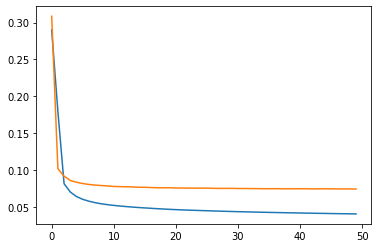

In [158]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [159]:
preds = magru.predict([X_train['left'], X_train['right']])
print(f"Train: {pearsonr([x[0] for x in preds.tolist()], sts_train['sim'])[0]}")
preds = magru.predict([X_test['left'], X_test['right']])
print(f"Test: {pearsonr([x[0] for x in preds.tolist()], df_test_aug['sim'])[0]}")
# mse = np.mean([(preds[x] - sts_test['sim'][x])**2 for x in range(len(sts_test))])
# print(f'MSE: {mse}')

Train: 0.731542145210667
Test: 0.46455478523922145


In [160]:
preds = magru.predict([X_test['left'], X_test['right']])

In [161]:
b_idx = 0
e_idx = b_idx + 5

p_avg = list()
while e_idx <= len(preds):
    p_avg.append(np.mean(preds[b_idx:e_idx]))
    b_idx += 5
    e_idx += 5

In [162]:
pearsonr(p_avg, sts_test['sim'])

(0.5371504718912663, 6.472534327535879e-104)

# SemEval-2014

In [601]:
df_train = pd.read_csv('./data/semeval_train_ko.csv')
df_train_norm = pd.read_csv('./data/semeval_train.csv')
df_test = pd.read_csv('./data/semeval_test_ko.csv')

# df_test = df_test.iloc[:len(df_test)-1, :]
df_test.tail()

,sent_1,sent_2,sim
4922,Little girl is blowing a big bubble,There is no girl in pink twirling a ribbon,2.1
4923,Dog in colored coat is running across the yard,The flute is being played by one man,1.0
4924,Boy happily playing the piano,A white bird lands quickly in the water,1.0
4925,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,1.0
4926,A man in the parking lot playing tennis on a l...,The snowboarder is leaping fearlessly over whi...,1.0


In [602]:
df_train.tail()

,sent_1,sent_2,sim
4495,The man is opening the door,A bald man in a band is playing guitar in the ...,1.1
4496,Someone is boiling okra in a pot,Man does not play drums,1.0
4497,Man singing sincerely and playing guitar,A bicyclist is holding a bike over his head in...,1.0
4498,The man in blue has a yellow ball in his fist,A man is jumping rope outside,1.2
4499,Three dogs are resting on the sidewalk,The woman with a knife is slicing a pepper,1.0


In [603]:
df_train_norm['sent_1'] = df_train_norm['sentence_A']
df_train_norm['sent_2'] = df_train_norm['sentence_B']
df_train_norm['sim'] = df_train_norm['relatedness_score']
df_train_norm = df_train_norm[['sent_1', 'sent_2', 'sim']]

In [604]:
df_test_norm = pd.read_csv('./data/semeval_test.csv')
df_test_norm['sim'] = norm(df_test_norm['relatedness_score'])
df_test_norm['sent_1'] =df_test_norm['sentence_A']
df_test_norm['sent_2'] = df_test_norm['sentence_B']
df_test_norm = df_test_norm[['sent_1', 'sent_2', 'sim']]
df_test_norm.tail()

,sent_1,sent_2,sim
4922,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,0.275
4923,A dog in a colored coat is running across the ...,The flute is being played by one man,0.000
4924,A boy is happily playing the piano,A white bird is landing swiftly in the water,0.000
4925,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,0.000
4926,A man is in a parking lot and is playing tenni...,The snowboarder is leaping fearlessly over whi...,0.000


In [605]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) 

In [606]:
df_train['sim'] = norm(df_train['sim'])
df_test['sim'] = norm(df_test['sim'])
df_train_norm['sim'] = norm(df_train_norm['sim'])
df_test_norm['sim'] = norm(df_test_norm['sim'])

In [607]:
df_test.tail()

,sent_1,sent_2,sim
4922,Little girl is blowing a big bubble,There is no girl in pink twirling a ribbon,0.275
4923,Dog in colored coat is running across the yard,The flute is being played by one man,0.000
4924,Boy happily playing the piano,A white bird lands quickly in the water,0.000
4925,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,0.000
4926,A man in the parking lot playing tennis on a l...,The snowboarder is leaping fearlessly over whi...,0.000


In [544]:
df_test['sent_1'] = df_test['sentence_A']
df_test['sent_2'] = df_test['sentence_B']

# df_train['sent_1'] = df_train['sentence_A']
# df_train['sent_2'] = df_train['sentence_B']

In [608]:
df_train = df_train.append(df_train_norm)
df_test = df_test.append(df_test_norm)

In [609]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [610]:
def clean_text(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [611]:
def prepare_embeddings(model, datasets, question_cols):
    vocabulary = dict()
    inverse_vocabulary = ['<unk>']
    questions_cols = question_cols

    # Iterate over the questions only of both training and test datasets
    for dataset in datasets:
        for index, row in dataset.iterrows():

            # Iterate through the text of both questions of the row
            for question in questions_cols:

                q2n = []  # q2n -> question numbers representation
                for word in text_to_word_list(row[question]):

                    # # Check for unwanted words
                    if word not in model.vocab:
                        continue

                    if word not in vocabulary:
                        vocabulary[word] = len(inverse_vocabulary)
                        q2n.append(len(inverse_vocabulary))
                        inverse_vocabulary.append(word)
                    else:
                        q2n.append(vocabulary[word])

                # Replace questions as word to question as number representationindex, question, q2n
                dataset.at[index, question]= q2n

    embedding_dim = model.vector_size
    embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
    embeddings[0] = 0  # So that the padding will be ignored

    # Build the embedding matrix
    for word, index in vocabulary.items():
        if word in model.vocab:
            embeddings[index] = model.word_vec(word)

    return embeddings, embedding_dim

In [211]:
# word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/enwiki_20180420_300d.txt')
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

In [612]:
embeddings, embedding_dim = prepare_embeddings(model=word2vec, datasets=[df_train, df_test], question_cols=['sent_1', 'sent_2'])

In [613]:
max_seq_length = max(df_train.sent_1.map(lambda x: len(x)).max(),
                     df_train.sent_2.map(lambda x: len(x)).max(),
                     df_test.sent_1.map(lambda x: len(x)).max(),
                     df_test.sent_2.map(lambda x: len(x)).max())

X_train = {'left': df_train.sent_1, 'right': df_train.sent_2}
X_test = {'left': df_test.sent_1, 'right': df_test.sent_2}

for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
        dataset[side] = tf.keras.preprocessing.sequence.pad_sequences(dataset[side], maxlen=max_seq_length)

In [644]:
def exponent_neg_manhattan_distance(left, right):
    """ Helper function for the similarity estimate of the LSTMs outputs"""
    return tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(left - right), axis=1, keepdims=True))

# The visible layer
left_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')
right_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length,
                                trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
# shared_gru = tf.keras.layers.GRU(100, name='gru', recurrent_activation='sigmoid', reset_after=True,
#                                 bias_initializer=tf.keras.initializers.Constant(2.5), dropout=0.0,
#                                 kernel_regularizer=None, recurrent_dropout=0.0)

# Since this is a siamese network, both sides share the same LSTM
shared_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, name='gru', recurrent_activation='sigmoid', reset_after=True,
                                                               bias_initializer=tf.keras.initializers.Constant(2.5), dropout=0.0,
                                                               kernel_regularizer=None, recurrent_dropout=0.0))


shared_dense = tf.keras.layers.Dense(50, activation='relu')
dp = tf.keras.layers.Dropout(0.25)

left_output = shared_gru(encoded_left)
right_output = shared_gru(encoded_right)

# left_output_den = shared_dense(left_output)
# right_output_den = shared_dense(right_output)

# left_output_dp = dp(left_output_den)
# right_output_dp = dp(right_output_den)

# Calculates the distance as defined by the MaLSTM model
magru_distance = tf.keras.layers.Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

magru = tf.keras.Model([left_input, right_input], [magru_distance])
optimizer=tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.985, clipvalue=2.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.5)

import tensorflow.keras.backend as K
def pear(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

magru.compile(loss='mean_squared_error', optimizer=optimizer)

In [645]:
hist = magru.fit([X_train['left'], X_train['right']], 
                np.array(df_train['sim']), 
                epochs=500, 
                batch_size=64,
                validation_data=([X_test['left'], X_test['right']], df_test['sim'])
                )

Epoch 1/500
141/141 [==============================] - 3s 22ms/step - loss: 0.0558 - val_loss: 0.0484
Epoch 2/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0455 - val_loss: 0.0427
Epoch 3/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0402 - val_loss: 0.0390
Epoch 4/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0367 - val_loss: 0.0365
Epoch 5/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0341 - val_loss: 0.0348
Epoch 6/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0323 - val_loss: 0.0335
Epoch 7/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0310 - val_loss: 0.0326
Epoch 8/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 9/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0289 - val_loss: 0.0312
Epoch 10/500
141/141 [==============================] - 2s 16ms/step - loss: 0.028

141/141 [==============================] - 2s 16ms/step - loss: 0.0140 - val_loss: 0.0234
Epoch 160/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0139 - val_loss: 0.0234
Epoch 161/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0139 - val_loss: 0.0234
Epoch 162/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0139 - val_loss: 0.0234
Epoch 163/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0139 - val_loss: 0.0234
Epoch 164/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0138 - val_loss: 0.0233
Epoch 165/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0138 - val_loss: 0.0233
Epoch 166/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0138 - val_loss: 0.0233
Epoch 167/500
141/141 [==============================] - 2s 17ms/step - loss: 0.0138 - val_loss: 0.0233
Epoch 168/500
141/141 [==============================] - 2s 17ms/step - loss: 

Epoch 238/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 239/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 240/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 241/500
141/141 [==============================] - 2s 15ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 242/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 243/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 244/500
141/141 [==============================] - 2s 15ms/step - loss: 0.0126 - val_loss: 0.0227
Epoch 245/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0127 - val_loss: 0.0227
Epoch 246/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0126 - val_loss: 0.0227
Epoch 247/500
141/141 [==============================] - 2s 16ms

Epoch 317/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 318/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 319/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 320/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 321/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 322/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0224
Epoch 323/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 324/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 325/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0120 - val_loss: 0.0225
Epoch 326/500
141/141 [==============================] - 2s 16ms

Epoch 396/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 397/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 398/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 399/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 400/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 401/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 402/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 403/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0116 - val_loss: 0.0223
Epoch 404/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0115 - val_loss: 0.0223
Epoch 405/500
141/141 [==============================] - 2s 16ms

Epoch 475/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 476/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 477/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 478/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0222
Epoch 479/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0113 - val_loss: 0.0222
Epoch 480/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0223
Epoch 481/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0223
Epoch 482/500
141/141 [==============================] - 2s 15ms/step - loss: 0.0112 - val_loss: 0.0222
Epoch 483/500
141/141 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0222
Epoch 484/500
141/141 [==============================] - 2s 16ms

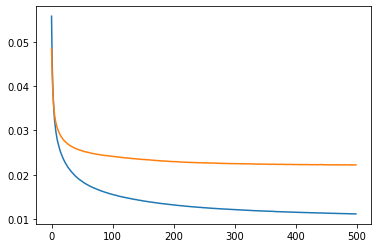

In [646]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [619]:
preds = magru.predict([X_train['left'], X_train['right']])
print(f"Train: {pearsonr([x[0] for x in preds.tolist()], df_train['sim'])[0]}")
preds = magru.predict([X_test['left'], X_test['right']])
print(f"Test: {pearsonr([x[0] for x in preds.tolist()], df_test['sim'])[0]}")

KeyboardInterrupt: 

In [ ]:
0.8131902365183467

In [642]:
preds = magru.predict([X_test['left'], X_test['right']])

In [643]:
b_idx = 0
e_idx = 4927

p_avg = list()
while e_idx < len(preds):
    first = preds[b_idx]
    second = preds[e_idx]
    p_avg.append(np.mean([first, second]))
    b_idx += 1
    e_idx += 1

In [640]:
pearsonr(p_avg, df_test_norm['sim'])

(0.8313927605992647, 0.0)

In [623]:
df_test_norm

,sent_1,sent_2,sim
0,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,0.57500
1,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,0.67500
2,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,0.50000
3,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,0.97500
4,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,0.66625
...,...,...,...
4922,The young girl is blowing a bubble that is huge,There is no girl in pink twirling a ribbon,0.27500
4923,A dog in a colored coat is running across the ...,The flute is being played by one man,0.00000
4924,A boy is happily playing the piano,A white bird is landing swiftly in the water,0.00000
4925,"The girl, who is little, is combing her hair i...",Two people wearing helmets are driving over th...,0.00000


In [624]:
df_test

,index,sent_1,sent_2,sim
0,0,"[135, 13, 16, 12, 3, 19, 16, 17, 396]","[1, 2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 4, 5, 11]",0.57500
1,1,"[1, 12, 13, 3, 4, 5, 6, 8, 9, 10, 4, 5, 11]","[18, 12, 13, 3, 19, 5, 8, 9, 20, 21]",0.67500
2,2,"[1, 2, 13, 3, 14, 15, 16, 17, 9, 10, 4, 5, 11]","[18, 12, 13, 3, 19, 5, 8, 9, 20, 21]",0.50000
3,3,"[31, 32, 9, 33, 34, 35, 4, 36, 338, 8, 4, 37]","[31, 32, 9, 33, 34, 35, 4, 36, 8, 4, 37]",0.97500
4,4,"[31, 32, 9, 33, 34, 35, 4, 36, 8, 4, 37]","[31, 32, 9, 1586, 34, 35, 4, 36, 8, 4, 37]",0.66625
...,...,...,...,...
9849,4922,"[5, 65, 102, 9, 675, 676, 349, 9, 677]","[135, 9, 16, 102, 4, 427, 2122, 2123]",0.27500
9850,4923,"[32, 4, 760, 446, 9, 127, 98, 5, 6]","[5, 854, 9, 416, 982, 219, 17, 8]",0.00000
9851,4924,"[182, 9, 589, 3, 5, 789]","[206, 1784, 9, 1288, 1243, 4, 5, 161]",0.00000
9852,4925,"[5, 102, 55, 9, 18, 9, 811, 236, 272, 58, 631,...","[26, 23, 153, 2186, 13, 788, 166, 5, 1777, 206...",0.00000


In [626]:
[1, 2, 3, 4, 5][[1, 5]]

TypeError: list indices must be integers or slices, not list

In [280]:
len(preds)

13499

In [284]:
len(p_avg)

4499

In [285]:
df_test_norm.shape

(4928, 6)

In [286]:
b_idx

13497

In [49]:
e_idx

9660

In [54]:
len(sts_test) * 7

9653

In [53]:
len(df_test_aug)

9653

In [60]:
b_idx

9653

In [59]:
df_test_aug.iloc[b_idx:e_idx, :]

,sent_1,sent_2,sim


In [61]:
preds

array([[0.77238864],
       [0.49613777],
       [0.88367546],
       ...,
       [0.3223548 ],
       [0.25252047],
       [0.2946713 ]], dtype=float32)

In [62]:
sts_test['sim']

0       0.50
1       0.72
2       1.00
3       0.84
4       0.30
        ... 
1374    0.00
1375    0.20
1376    0.20
1377    0.00
1378    0.00
Name: sim, Length: 1379, dtype: float64

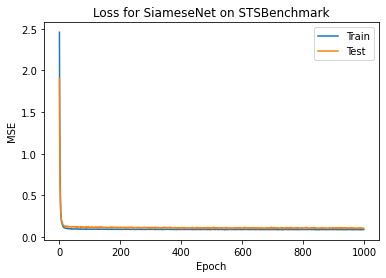

In [341]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss for SiameseNet on STSBenchmark')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'])
plt.savefig('./results/sts_loss.png', dpi=400)

In [216]:
preds = magru.predict([X_test['left'], X_test['right']])

In [217]:
preds

array([[0.90131104],
       [0.9376601 ],
       [0.9610757 ],
       ...,
       [0.5535589 ],
       [0.21903707],
       [0.4240261 ]], dtype=float32)

In [233]:
sts_plot = pd.DataFrame({
    'actual': sts_test['sim'].tolist(),
    'preds': [x[0] for x in preds]
})
sts_plot.sort_values('actual')

,actual,preds
1499,0.0,0.424026
93,0.0,0.146512
727,0.0,0.119679
728,0.0,0.224491
370,0.0,0.287769
...,...,...
134,1.0,0.950776
135,1.0,0.950776
1123,1.0,0.861014
137,1.0,0.781642


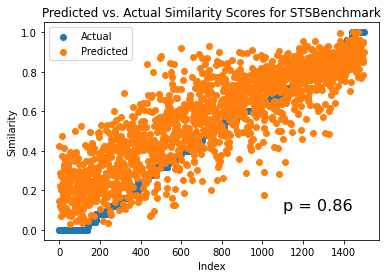

In [251]:
plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['actual'])
plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['preds'])
plt.legend(['Actual', 'Predicted'])
plt.title('Predicted vs. Actual Similarity Scores for STSBenchmark')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.text(x=1100, y=0.1, s='p = 0.86', size=16)
plt.savefig('./results/stsbenchmark.png', dpi=400)

In [256]:
magru.save_weights('./models/siam/sts')

In [446]:
file = open('./data/semeval.txt', 'r')
headers = file.readline().split('\t')

file = open('./data/semeval.txt', 'r')
data = list()
for line in file:
    data.append(line.split('\t'))
data = data[1:]

data = pd.DataFrame(data, columns=headers)
data['relatedness_score'] = pd.to_numeric(data['relatedness_score'])
data = data.iloc[:len(data)-1,:]
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment\n
0,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,NEUTRAL\n
1,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,NEUTRAL\n
2,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,NEUTRAL\n
3,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,ENTAILMENT\n
4,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,NEUTRAL\n


In [447]:
file = open('./data/semeval_train.txt', 'r')
headers = file.readline().split('\t')

file = open('./data/semeval_train.txt', 'r')
data_train = list()
for line in file:
    data_train.append(line.split('\t'))
data_train = data_train[1:]

data_train = pd.DataFrame(data_train, columns=headers)
data_train['relatedness_score'] = pd.to_numeric(data_train['relatedness_score'])
data_train.tail()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment\n
4495,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,1.1,NEUTRAL\n
4496,9997,Someone is boiling okra in a pot,The man is not playing the drums,1.0,NEUTRAL\n
4497,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,1.0,NEUTRAL\n
4498,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,1.2,NEUTRAL\n
4499,10000,Three dogs are resting on a sidewalk,The woman with a knife is slicing a pepper,1.0,NEUTRAL\n


In [448]:
data['normed_score'] = norm(data['relatedness_score'])
data_train['normed_score'] = norm(data_train['relatedness_score'])

In [364]:
embeddings, embedding_dim = prepare_embeddings(model=word2vec, datasets=[data_train, data], question_cols=['sentence_A', 'sentence_B'])

In [365]:
max_seq_length = max(data_train.sentence_A.map(lambda x: len(x)).max(),
                     data_train.sentence_B.map(lambda x: len(x)).max(),
                     data.sentence_A.map(lambda x: len(x)).max(),
                     data.sentence_B.map(lambda x: len(x)).max())

In [366]:
X_train = {'left': data_train.sentence_A, 'right': data_train.sentence_B}
X_test = {'left': data.sentence_A, 'right': data.sentence_B}

In [367]:
for dataset, side in itertools.product([X_train, X_test], ['left', 'right']):
        dataset[side] = tf.keras.preprocessing.sequence.pad_sequences(dataset[side], maxlen=max_seq_length)

In [437]:
def exponent_neg_manhattan_distance(left, right):
    """ Helper function for the similarity estimate of the LSTMs outputs"""
    return tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(left - right), axis=1, keepdims=True))

# The visible layer
left_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')
right_input = tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length,
                                trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_gru = tf.keras.layers.GRU(100, name='gru', recurrent_activation='sigmoid', reset_after=True,
                                bias_initializer=tf.keras.initializers.Constant(2.5), dropout=0.0)

left_output = shared_gru(encoded_left)
right_output = shared_gru(encoded_right)

# Calculates the distance as defined by the MaLSTM model
magru_distance = tf.keras.layers.Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

magru = tf.keras.Model([left_input, right_input], [magru_distance])
optimizer=tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.985, clipvalue=2.0)

import tensorflow.keras.backend as K
def pear(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

magru.compile(loss='mean_squared_error', optimizer=optimizer)

In [438]:
hist = magru.fit([X_train['left'], X_train['right']], 
                np.array(data_train['normed_score']), 
                epochs=500, 
                batch_size=64,
               validation_data=([X_test['left'], X_test['right']], data['normed_score']))

Epoch 1/500
71/71 [==============================] - 1s 17ms/step - loss: 0.0669 - val_loss: 0.0559
Epoch 2/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0523 - val_loss: 0.0480
Epoch 3/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0454 - val_loss: 0.0425
Epoch 4/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0401 - val_loss: 0.0384
Epoch 5/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0360 - val_loss: 0.0356
Epoch 6/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0337 - val_loss: 0.0337
Epoch 7/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0316 - val_loss: 0.0323
Epoch 8/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0304 - val_loss: 0.0313
Epoch 9/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0292 - val_loss: 0.0305
Epoch 10/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0285 - val_loss: 0.0299

71/71 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0210
Epoch 163/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0210
Epoch 164/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0210
Epoch 165/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0124 - val_loss: 0.0210
Epoch 166/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0122 - val_loss: 0.0210
Epoch 167/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0122 - val_loss: 0.0210
Epoch 168/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0122 - val_loss: 0.0210
Epoch 169/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0122 - val_loss: 0.0209
Epoch 170/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0122 - val_loss: 0.0209
Epoch 171/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0121 - val_loss: 0

71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 323/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 324/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 325/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 326/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 327/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 328/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 329/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0102 - val_loss: 0.0204
Epoch 330/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0102 - val_loss: 0.0204
Epoch 331/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0102 - val_loss: 0

71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 483/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 484/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0094 - val_loss: 0.0202
Epoch 485/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0094 - val_loss: 0.0202
Epoch 486/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 487/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 488/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 489/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 490/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 491/500
71/71 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0

In [435]:
preds = magru.predict([X_train['left'], X_train['right']])
print(f"Train: {pearsonr([x[0] for x in preds.tolist()], data_train['normed_score'])[0]}")
preds = magru.predict([X_test['left'], X_test['right']])
print(f"Test: {pearsonr([x[0] for x in preds.tolist()], data['normed_score'])[0]}")

Train: 0.9390291036484004
Test: 0.8343675704582418


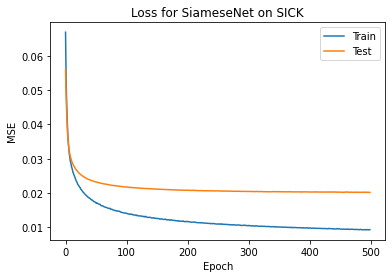

In [526]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss for SiameseNet on SICK')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'])
# plt.savefig('./results/sick_loss.png', dpi=400)

In [416]:
preds = magru.predict([X_test['left'], X_test['right']])

In [515]:
sts_plot = pd.DataFrame({
    'actual': data['normed_score'].tolist(),
    'preds': [x[0] for x in preds]
})


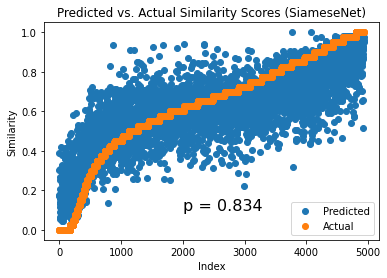

In [517]:
plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['preds'])
plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['actual'])
plt.legend(['Predicted', 'Actual'])
plt.title('Predicted vs. Actual Similarity Scores (SiameseNet)')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.text(x=2000, y=0.1, s='p = 0.834', size=16)
plt.savefig('./results/sick.png', dpi=400)

In [406]:
magru.save_weights('./models/siam/sick')

In [472]:
a = [2.7654870801855078, 0.35995355443076027, 0.016221679989074141, -0.012664358453398751, 0.0036888812311235068]
b = [-6.2588482809118942, -0.88952297609194686, 0.017336984676103874, -0.0054928004763216964, 0.011122959185936367]

print(-(cosine(a,b) - 1))

-0.9998750139273809


#### Failed attempts

In [23]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(256, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)




manhattan = lambda x: tf.keras.backend.exp(tf.keras.backend.abs(x[0] - x[1]))
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=1.5), 
                    loss='mse')

In [37]:
def exponent_neg_manhattan_distance(left, right):
    """ Helper function for the similarity estimate of the LSTMs outputs"""
    return tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(left - right), axis=1, keepdims=True))


input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)

siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(100, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)

manhat_dist = tf.keras.layers.Lambda(
    function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
     output_shape=lambda x: (x[0][0], 1))([encoded_l, encoded_r]
)

siamese_net = tf.keras.Model([left_input, right_input], manhat_dist)

siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipnorm=1.25), 
                    loss='mse')

In [38]:
hist = siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(sts_train['normed_score']), 
                epochs=500, 
                batch_size=64,
               validation_data=([np.array(test_a), np.array(test_b)], sts_test['normed_score']))

Epoch 1/500
90/90 [==============================] - 2s 17ms/step - loss: 0.0979 - val_loss: 0.1159
Epoch 2/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0926 - val_loss: 0.1108
Epoch 3/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0881 - val_loss: 0.1042
Epoch 4/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0845 - val_loss: 0.1016
Epoch 5/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0827 - val_loss: 0.0995
Epoch 6/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0812 - val_loss: 0.0983
Epoch 7/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0795 - val_loss: 0.0974
Epoch 8/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0785 - val_loss: 0.0964
Epoch 9/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0781 - val_loss: 0.0958
Epoch 10/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0769 - val_loss: 0.0953

90/90 [==============================] - 1s 12ms/step - loss: 0.0552 - val_loss: 0.0864
Epoch 163/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0559 - val_loss: 0.0863
Epoch 164/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0555 - val_loss: 0.0860
Epoch 165/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0560 - val_loss: 0.0857
Epoch 166/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0554 - val_loss: 0.0866
Epoch 167/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0555 - val_loss: 0.0868
Epoch 168/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0551 - val_loss: 0.0870
Epoch 169/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0553 - val_loss: 0.0863
Epoch 170/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0551 - val_loss: 0.0863
Epoch 171/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0553 - val_loss: 0

90/90 [==============================] - 1s 12ms/step - loss: 0.0522 - val_loss: 0.0858
Epoch 323/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0526 - val_loss: 0.0867
Epoch 324/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0515 - val_loss: 0.0866
Epoch 325/500
90/90 [==============================] - 1s 13ms/step - loss: 0.0521 - val_loss: 0.0861
Epoch 326/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0521 - val_loss: 0.0863
Epoch 327/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0525 - val_loss: 0.0870
Epoch 328/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0518 - val_loss: 0.0864
Epoch 329/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0517 - val_loss: 0.0864
Epoch 330/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0522 - val_loss: 0.0873
Epoch 331/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0522 - val_loss: 0

90/90 [==============================] - 1s 13ms/step - loss: 0.0512 - val_loss: 0.0857
Epoch 483/500
90/90 [==============================] - 1s 13ms/step - loss: 0.0500 - val_loss: 0.0860
Epoch 484/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0502 - val_loss: 0.0861
Epoch 485/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0505 - val_loss: 0.0861
Epoch 486/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0504 - val_loss: 0.0859
Epoch 487/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0506 - val_loss: 0.0861
Epoch 488/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0496 - val_loss: 0.0851
Epoch 489/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0503 - val_loss: 0.0857
Epoch 490/500
90/90 [==============================] - 1s 12ms/step - loss: 0.0500 - val_loss: 0.0857
Epoch 491/500
90/90 [==============================] - 1s 13ms/step - loss: 0.0498 - val_loss: 0

In [39]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Train: {pearsonr([x[0] for x in preds.tolist()], sts_train['normed_score'])[0]}")
preds = siamese_net.predict([np.array(test_a), np.array(test_b)])
print(f"Test: {pearsonr([x[0] for x in preds.tolist()], sts_test['normed_score'])[0]}")

Train: 0.6983347681067998
Test: 0.48304227536519245


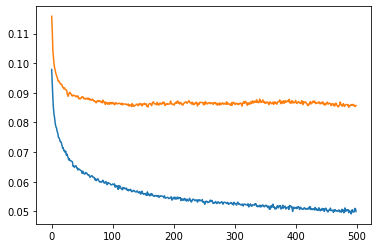

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

#### Testing USE

In [443]:
!pip install tensorflow-hub

     |████████████████████████████████| 101 kB 4.9 MB/s ta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [452]:
import tensorflow_hub as hub
from scipy.spatial.distance import cosine

In [445]:
# Loading up the embedding layer...
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
use_model = hub.KerasLayer(use_url, trainable=False)

In [451]:
use_model(data_train['sentence_A']).numpy()

array([[-0.06608703,  0.0574947 , -0.01160311, ..., -0.02843104,
         0.01001185,  0.02347358],
       [-0.02112009,  0.05138672, -0.0064065 , ..., -0.00271566,
         0.04889863,  0.00453754],
       [-0.03194014,  0.07775315, -0.05130988, ...,  0.05198707,
        -0.0646082 ,  0.03915566],
       ...,
       [-0.02353627,  0.01033876,  0.10228971, ..., -0.01280252,
        -0.07449164,  0.02618971],
       [-0.02190577,  0.02311402, -0.0801158 , ...,  0.02143592,
         0.00990087,  0.00959624],
       [-0.02485645,  0.0554212 ,  0.04666391, ...,  0.03585761,
        -0.03794718,  0.00068345]], dtype=float32)

In [462]:
# 0 = perfect similarityt
cosine(use_model([data_train['sentence_A'][0]]).numpy(), 
       use_model([data_train['sentence_B'][0]]).numpy())

0.21873575448989868

In [463]:
data_train['normed_score']

0       0.875
1       0.550
2       0.925
3       0.600
4       0.675
        ...  
4495    0.025
4496    0.000
4497    0.000
4498    0.050
4499    0.000
Name: normed_score, Length: 4500, dtype: float64

In [473]:
def cossim(x,y):
    return -(cosine(x,y) - 1)

In [511]:
use_simil = [cossim(use_model([data['sentence_A'][x]]), use_model([data['sentence_B'][x]])) for x in range(len(data))]

In [482]:
pearsonr(norm(use_simil), data_train['normed_score'])

(0.7760975814137541, 0.0)

In [525]:
pearsonr([1 - use_simil[x] for x in range(len(use_simil))], data['normed_score'])

(-0.7711464242647449, 0.0)

Text(2000, 0.1, 'p = 0.776')

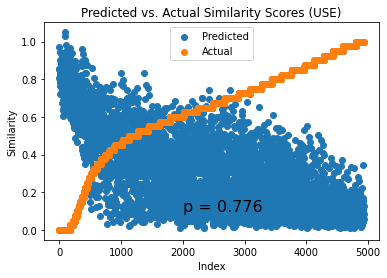

In [522]:
sts_plot = pd.DataFrame({
    'actual': data['normed_score'].tolist(),
    'preds': [1 - use_simil[x] for x in range(len(use_simil))]
})

plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['preds'])
plt.scatter(x=[x for x in range(len(sts_plot))],
            y=sts_plot.sort_values('actual')['actual'])
plt.legend(['Predicted', 'Actual'])
plt.title('Predicted vs. Actual Similarity Scores (USE)')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.text(x=2000, y=0.1, s='p = 0.776', size=16)
# plt.savefig('./results/sick_use.png', dpi=400)

In [521]:
[1 - use_simil[x] for x in range(len(use_simil))]

[0.5904361009597778,
 0.4980056881904602,
 0.6018387675285339,
 0.06102311611175537,
 0.10316848754882812,
 0.16162806749343872,
 0.7003941535949707,
 0.6231006383895874,
 0.6375586688518524,
 0.07068800926208496,
 0.16717803478240967,
 0.09676086902618408,
 0.10559290647506714,
 0.21175146102905273,
 0.7165170013904572,
 0.6023523509502411,
 0.2604421377182007,
 0.153228759765625,
 0.17473310232162476,
 0.267844557762146,
 0.6002654433250427,
 0.3791876435279846,
 0.34755241870880127,
 0.3716665506362915,
 0.188795804977417,
 0.03794938325881958,
 0.47953569889068604,
 0.6440955102443695,
 0.436232328414917,
 0.43879061937332153,
 0.026356995105743408,
 0.1205453872680664,
 0.16650211811065674,
 0.47273164987564087,
 0.4649462103843689,
 0.48310917615890503,
 0.48823755979537964,
 0.12997525930404663,
 0.15398037433624268,
 0.17464131116867065,
 0.13946259021759033,
 0.24216389656066895,
 0.23953568935394287,
 0.1741187572479248,
 0.03836625814437866,
 0.16312211751937866,
 0.13893514

In [509]:
len(data['normed_score'].tolist())

4927

In [510]:
len(use_simil)

4500

In [467]:
use_simil = [cossim(use_model([data['sentence_A'][x]]), use_model([data['sentence_B'][x]])) for x in range(len(data))]

In [468]:
pearsonr(use_simil, data['normed_score'])

(-0.7711464249136771, 0.0)

In [489]:
a = np.array([np.random.randint(10) for _ in range(20)])

In [490]:
np.linalg.norm(a, 2)

16.3707055437449

In [502]:
np.dot(a,a) / ((np.dot(a, a)) ** (1/2) * (np.dot(a, a)) ** (1/2))

1.0

In [498]:
cosine(a,a)

0.0

In [500]:
1 - (np.dot(a, a) / (np.linalg.norm(a) * np.linalg.norm(a)))

0.0

In [503]:
cosine(a,a)

0.0

In [12]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) 

In [22]:
df_test = pd.read_csv('./data/Stsbenchmark/test.csv')


def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x)) 

df_test['normed_score'] = norm(df_test['score'])

df_test.head()

,test,yr,id,score,sentence_A,sentence_B,normed_score
0,MSRvid,2012test,24,2.5,A girl is styling her hair.,A girl is brushing her hair.,0.50
1,MSRvid,2012test,33,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.72
2,MSRvid,2012test,45,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.00
3,MSRvid,2012test,63,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.84
4,MSRvid,2012test,66,1.5,A man is playing a harp.,A man is playing a keyboard.,0.30


In [69]:
np.unique(df_train['desc'])

array(['MSRpar', 'MSRvid', 'deft-forum', 'deft-news', 'headlines',
       'images'], dtype=object)

In [71]:
np.unique(df_test['test'])

array(['MSRpar', 'MSRvid', 'answer-answer', 'headlines', 'images',
       'track5.en-en'], dtype=object)

In [23]:
df_train['sentence_A'] = [x.lower() for x in df_train['sentence_A']]
df_train['sentence_B'] = [x.lower() for x in df_train['sentence_B']]
df_test['sentence_A'] = [x.lower() for x in df_test['sentence_A']]
df_test['sentence_B'] = [x.lower() for x in df_test['sentence_B']]

In [24]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./models/enwiki_20180420_300d.txt')

In [74]:
df_train[df_train['desc'] == 'images'].reset_index()

,index,data,desc,yr,id,score,sentence_A,sentence_B,normed_score
0,1000,main-captions,images,2014,1,4.4,two green and white trains sitting on the tracks.,two green and white trains on tracks.,0.88
1,1001,main-captions,images,2014,2,2.6,a small white cat with glowing eyes standing u...,a white cat stands on the floor.,0.52
2,1002,main-captions,images,2014,3,3.2,a large boat in the water at the marina.,a large boat on the sea.,0.64
3,1003,main-captions,images,2014,4,4.0,a bus driving in a street.,red double decker bus driving down street.,0.80
4,1004,main-captions,images,2014,6,4.8,a passenger train waiting in a station.,a passenger train sits in the station.,0.96
...,...,...,...,...,...,...,...,...,...
995,1995,main-captions,images,2015,1488,2.0,dog running towards camera with a ball in its ...,the black and white dog swims with a brown obj...,0.40
996,1996,main-captions,images,2015,1489,4.2,a young girl running on the beach.,a little girl running at on the shore of a beach.,0.84
997,1997,main-captions,images,2015,1490,1.6,a baseball player throws the ball.,the basketball player holds the ball.,0.32
998,1998,main-captions,images,2015,1493,3.0,a man is swinging on a rope over water.,a man in a maroon bathing suit swings on a rop...,0.60


In [76]:
df_train_images = df_train[df_train['desc'] == 'images'].reset_index()
df_test_images = df_test[df_test['test'] == 'images'].reset_index()

In [81]:
m = 0
for i in range(len(df_test_images)):
    if len(df_test_images['sentence_A'][i].split(' ')) > m:
        m = len(df_test_images['sentence_A'][i].split(' '))
m

19

In [80]:
m = 0
for i in range(len(df_test_images)):
    if len(df_test_images['sentence_B'][i].split(' ')) > m:
        m = len(df_test_images['sentence_B'][i].split(' '))
m

20

In [82]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_train_images)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_train_images['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_train_images['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 27:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 27:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [83]:
"""TESTING DATA"""
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_images)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_images['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_images['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 27:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 27:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))
    
with open('./data/test_a_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

### Network

In [84]:
"""DATA DEFINITION"""
train_a = pickle.load(open('./data/train_a_images_w2v300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_images_w2v300.data', 'rb'))
test_a = pickle.load(open('./data/test_a_images_w2v300.data', 'rb'))
test_b = pickle.load(open('./data/test_b_images_w2v300.data', 'rb'))

In [143]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(0.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5,
                                                           rho=0.9,
                                                           clipvalue=1.5), 
                    loss='mse')

In [144]:
siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(df_train_images['normed_score']), 
                epochs=300, 
                batch_size=32)

Epoch 1/300
32/32 [==============================] - 0s 7ms/step - loss: 0.3532
Epoch 2/300
32/32 [==============================] - 0s 7ms/step - loss: 0.3054
Epoch 3/300
32/32 [==============================] - 0s 7ms/step - loss: 0.2239
Epoch 4/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1771
Epoch 5/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1654
Epoch 6/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1616
Epoch 7/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1465
Epoch 8/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1461
Epoch 9/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1382
Epoch 10/300
32/32 [==============================] - 0s 7ms/step - loss: 0.1287
Epoch 11/300
32/32 [==============================] - 0s 8ms/step - loss: 0.1254
Epoch 12/300
32/32 [==============================] - 0s 8ms/step - loss: 0.1218
Epoch 13/300
32/32 [=================

32/32 [==============================] - 0s 7ms/step - loss: 0.0349
Epoch 203/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 204/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 205/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0355
Epoch 206/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0351
Epoch 207/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 208/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0322
Epoch 209/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0334
Epoch 210/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0322
Epoch 211/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0362
Epoch 212/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 213/300
32/32 [==============================] - 0s 7ms/step - loss: 0.0318
Epoch 214/300
32/32 [=========

In [145]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_train_images['normed_score'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_train_images['normed_score'])[0]}")

Pearsons: 0.9561392711587636
Spearmans: 0.9465485981672122


In [146]:
preds = siamese_net.predict([np.array(test_a), np.array(test_b)]) #53.7
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_test_images['normed_score'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_test_images['normed_score'])[0]}")

Pearsons: 0.4570436504390102
Spearmans: 0.4217631754731278


In [125]:
"""
50, glorot_uniform, 2.5, 0.35, Adadelta(0.5, 0.9, 1.5)
"""
siamese_net.save_weights('./models/siam/images/') # 0.7010318394360036

## Headlines (2015)

#### preparing training data

In [249]:
file = open('./data/sts2015_headlines/train_input.txt', 'r')
data = list()
for line in file:
    data.append(line.split('\t'))

In [250]:
len(data)

1500

In [251]:
file = open('./data/sts2015_headlines/train_scores.txt', 'r')
labels = list()
for line in file:
    labels.append(line)

In [252]:
for i in range(len(labels)):
    if labels[i] == '\n':
        labels[i] = None
    if type(labels[i]) == str:
        labels[i] = float(labels[i].replace('\n', ''))

In [253]:
df_train_headlines = pd.DataFrame(data, columns=['sentence_A', 'sentence_B'])
df_train_headlines['score'] = labels
df_train_headlines['normed_scre'] = norm(df_train_headlines['score'])

#### preparing test data

In [279]:
file = open('./data/sts2015_headlines/test_all.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    test.append(a)
df_test_headlines = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])
df_test_headlines = df_test_headlines.iloc[:750,:]
df_test_headlines['scores'] = [float(x) for x in df_test_headlines['scores']]
df_test_headlines['normed_scre'] = norm(df_test_headlines['scores'])

In [241]:
m = 0
for i in range(len(df_train_headlines)):
    if len(df_train_headlines['sentence_A'][i].split(' ')) > m:
        m = len(df_train_headlines['sentence_A'][i].split(' '))
m

35

In [281]:
m = 0
for i in range(len(df_test_headlines)):
    if len(df_test_headlines['sentence_B'][i].split(' ')) > m:
        m = len(df_test_headlines['sentence_B'][i].split(' '))
m

27

In [243]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_train_headlines)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_train_headlines['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_train_headlines['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 35:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 35:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [282]:
"""TESTING DATA"""
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_headlines)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_headlines['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_headlines['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 27:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 27:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))
    
with open('./data/test_a_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

#### Modeling

In [356]:
"""DATA DEFINITION"""
train_a = pickle.load(open('./data/train_a_headlines_w2v300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_headlines_w2v300.data', 'rb'))
test_a = pickle.load(open('./data/test_a_headlines_w2v300.data', 'rb'))
test_b = pickle.load(open('./data/test_b_headlines_w2v300.data', 'rb'))

In [359]:
type(train_b[0])

numpy.ndarray

In [285]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(0.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.5,
                                                           rho=0.9,
                                                           clipvalue=1.5), 
                    loss='mse')

In [342]:
siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(df_train_headlines['normed_scre']), 
                epochs=50, 
                batch_size=32)

Epoch 1/50
47/47 [==============================] - 0s 8ms/step - loss: 0.3516
Epoch 2/50
47/47 [==============================] - 0s 8ms/step - loss: 0.3212
Epoch 3/50
47/47 [==============================] - 0s 8ms/step - loss: 0.2823
Epoch 4/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1814
Epoch 5/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1462
Epoch 6/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1354
Epoch 7/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1235
Epoch 8/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1159
Epoch 9/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1087
Epoch 10/50
47/47 [==============================] - 0s 8ms/step - loss: 0.1027
Epoch 11/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0999
Epoch 12/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0963
Epoch 13/50
47/47 [==============================

In [317]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_train_headlines['normed_scre'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_train_headlines['normed_scre'])[0]}")

Pearsons: 0.959683653388316
Spearmans: 0.9567902315961634


In [318]:
preds = siamese_net.predict([np.array(test_a), np.array(test_b)]) #53.7
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_test_headlines['normed_scre'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_test_headlines['normed_scre'])[0]}")

Pearsons: 0.8711128255491617
Spearmans: 0.8600551135784084


In [315]:
"""
50, glorot_uniform, 0.5, 0.35, Adadelta(0.5, 0.9, 1.5), 600
"""
siamese_net.save_weights('./models/siam/headlines/') # 0.8746802156351821

#### All data

In [329]:
file = open('./data/semeval_2015_all_train.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    test.append(a)
df_train_all = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])
df_train_all = df_train_all.iloc[:3000,:]
df_train_all['scores'] = [float(x) for x in df_train_all['scores']]
df_train_all['normed_scre'] = norm(df_train_all['scores'])

In [384]:
file = open('./data/onwn_test.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    test.append(a)
df_test_own = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])

df_test_own = df_test_own.iloc[:len(df_test_own)-1,:]
df_test_own['scores'] = [float(x) for x in df_test_own['scores']]
df_test_own['normed_scre'] = norm(df_test_own['scores'])
df_test_own.head()

,scores,sentence_A,sentence_B,normed_scre
0,4.0,the activity of learning or being trained,the gradual process of acquiring knowledge.,0.80
1,3.8,thin metal strips used in typesetting,thin strip of metal used to separate lines of ...,0.76
2,4.2,falcon: abandon intended game and pursue lesse...,"abandon the intended prey, turn, and pursue an...",0.84
3,1.8,the act of designating a role to someone,the act of designating or identifying something.,0.36
4,4.0,make pure or free from sin,make pure or free from sin or guilt.,0.80


In [379]:
m = 0
for i in range(len(df_test_own)):
    if len(df_test_own['sentence_A'][i].split(' ')) > m:
        m = len(df_test_own['sentence_A'][i].split(' '))
m

21

In [380]:
m = 0
for i in range(len(df_test_own)):
    if len(df_test_own['sentence_B'][i].split(' ')) > m:
        m = len(df_test_own['sentence_B'][i].split(' '))
m

21

In [381]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_own)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_own['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_own['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 21:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 21:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_own_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_own_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [452]:
sc = SpellChecker()

In [455]:
sc.correction('453')

'453'

In [474]:
file = open('./data/forum_test.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '').replace('"', '') for x in a]
    test.append(a)
df_test_forum = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])

df_test_forum = df_test_forum.iloc[:len(df_test_forum)-1,:]
df_test_forum['scores'] = [float(x) for x in df_test_forum['scores']]
df_test_forum['normed_scre'] = norm(df_test_forum['scores'])
print(df_test_forum.head())

m = 0
for i in range(len(df_test_forum)):
    if len(df_test_forum['sentence_A'][i].split(' ')) > m:
        m = len(df_test_forum['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_test_forum)):
    if len(df_test_forum['sentence_B'][i].split(' ')) > m:
        m = len(df_test_forum['sentence_B'][i].split(' '))
print(m)


   scores                                         sentence_A  \
0     3.0  How about some testimonies from real health ex...   
1     0.8                         Then the captain was gone.   
2     3.8                  The problem is simpler than that.   
3     1.0              NEGATIVE RECONNAISSANCE REQUIREMENTS.   
4     0.4  So, I am dropping, for now, asking you the que...   

                                          sentence_B  normed_scre  
0  Also, who's to say there aren't testimonies fr...         0.60  
1                        Then the captain came back.         0.16  
2                             The problem is simple.         0.76  
3                             PACIFIC REQUIREMENTS .         0.20  
4  I am moving on to ask you the question:  Where...         0.08  
18
17


In [466]:
correctedA = list()
correctedB = list()
for i in tqdm(range(len(df_test_forum))):
    corA = ' '.join([sc.correction(x) for x in df_test_forum['sentence_A'][i].split(' ')])
    corB = ' '.join([sc.correction(x) for x in df_test_forum['sentence_B'][i].split(' ')])
    correctedA.append(corA)
    correctedB.append(corB)
df_test_forum['sentence_A'][0]

100%|██████████| 450/450 [03:14<00:00,  2.32it/s]


'How about some testimonies from real health experts?'

In [467]:
df_test_forum['sentence_A'] = correctedA
df_test_forum['sentence_B'] = correctedB

In [472]:
df_test_forum['sentence_B']

0      also whos to say there arendt testimonies from...
1                             Then the captain came back
2                                  The problem is simple
3                                 PACIFIC REQUIREMENTS .
4      I am moving on to ask you the question " Where...
                             ...                        
445                   What is your definition of "soul"?
446    Aye but they ARE responsible to their constitu...
447    The ideology was built around violent expansio...
448             @ossobuco, Could this have been an enema
449       taking advantage has the effect of reinforcing
Name: sentence_B, Length: 450, dtype: object

In [475]:
"""TRAINING DATA"""
# 57 is the longest sentence. 1so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_forum)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_forum['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_forum['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 18:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 18:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_forum_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_forum_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [388]:
file = open('./data/news_test.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    test.append(a)
df_test_news = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])

df_test_news = df_test_news.iloc[:len(df_test_news)-1,:]
df_test_news['scores'] = [float(x) for x in df_test_news['scores']]
df_test_news['normed_scre'] = norm(df_test_news['scores'])
print(df_test_news.head())

m = 0
for i in range(len(df_test_news)):
    if len(df_test_news['sentence_A'][i].split(' ')) > m:
        m = len(df_test_news['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_test_news)):
    if len(df_test_news['sentence_B'][i].split(' ')) > m:
        m = len(df_test_news['sentence_B'][i].split(' '))
print(m)


   scores                                         sentence_A  \
0     4.0      mexico wishes to guarantee citizens' safety.    
1     4.2  spain currently holds the rotating presidency ...   
2     4.2              the treaty was first signed in 1990.    
3     3.2     gorgich and pashtoon were executed in prison.    
4     0.6  safe bourada was sentenced to 15 years in pris...   

                                          sentence_B  normed_scre  
0              mexico wishes to avoid more violence.         0.80  
1       spain currently holds the osce's presidency.         0.84  
2                 the cfe treaty was signed in 1990.         0.84  
3  gorgich and pashtoon were executed for traffic...         0.64  
4        djamel badaoui was sentenced to five years.         0.12  
57
48


In [389]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_news)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_news['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_news['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 57:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 57:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_news_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_news_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [390]:
file = open('./data/images_test.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    test.append(a)
df_test_images = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])

df_test_images = df_test_images.iloc[:len(df_test_images)-1,:]
df_test_images['scores'] = [float(x) for x in df_test_images['scores']]
df_test_images['normed_scre'] = norm(df_test_images['scores'])
print(df_test_images.head())

m = 0
for i in range(len(df_test_images)):
    if len(df_test_images['sentence_A'][i].split(' ')) > m:
        m = len(df_test_images['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_test_images)):
    if len(df_test_images['sentence_B'][i].split(' ')) > m:
        m = len(df_test_images['sentence_B'][i].split(' '))
print(m)


   scores                                         sentence_A  \
0     3.6                   A cat standing on tree branches.   
1     4.4  Two green and white trains sitting on the tracks.   
2     2.6  A small white cat with glowing eyes standing u...   
3     3.2           A large boat in the water at the marina.   
4     4.0                         a bus driving in a street.   

                                          sentence_B  normed_scre  
0  A black and white cat is high up on tree branc...         0.72  
1              Two green and white trains on tracks.         0.88  
2                   A white cat stands on the floor.         0.52  
3                           A large boat on the sea.         0.64  
4         Red double decker bus driving down street.         0.80  
22
27


In [391]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_images)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_images['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_images['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 27:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 27:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_images_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [524]:
file = open('./data/headlines_2013_test.txt')
test = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '').replace('#', '') for x in a]
    test.append(a)
df_test_headlines = pd.DataFrame(test, columns=['scores', 'sentence_A', 'sentence_B'])

df_test_headlines = df_test_headlines.iloc[:len(df_test_headlines)-1,:]
df_test_headlines['scores'] = [float(x) for x in df_test_headlines['scores']]
df_test_headlines['normed_scre'] = norm(df_test_headlines['scores'])
print(df_test_fnwn.head())

m = 0
for i in range(len(df_test_headlines)):
    if len(df_test_headlines['sentence_A'][i].split(' ')) > m:
        m = len(df_test_headlines['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_test_headlines)):
    if len(df_test_headlines['sentence_B'][i].split(' ')) > m:
        m = len(df_test_headlines['sentence_B'][i].split(' '))
print(m)


   scores                                         sentence_A  \
0     0.6  there exist a number of different possible eve...   
1     0.8  this frame contians lus which are like those o...   
2     0.8  a recipient starts off without the theme in th...   
3     1.2  this frame concerns a specific subset of insta...   
4     0.4  this frame contains words that describe an ite...   

                                          sentence_B  normed_scre  
0                   doing as one pleases or chooses;         0.15  
1  being or characteristic of or appropriate to e...         0.20  
2               win something through one's efforts;         0.20  
3                     a standard or typical example;         0.30  
4  lacking in specific resources, qualities or su...         0.10  
22
16


In [525]:

"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_test_headlines)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_test_headlines['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_test_headlines['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 22:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 22:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_headlines_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

##### Modeling

In [526]:
"""DATA DEFINITION"""
train_a = pickle.load(open('./data/train_a_all_w2v300.data', 'rb'))
train_b = pickle.load(open('./data/train_b_all_w2v300.data', 'rb'))

test_a_head = pickle.load(open('./data/test_a_headlines_w2v300.data', 'rb'))
test_b_head = pickle.load(open('./data/test_b_headlines_w2v300.data', 'rb'))
test_a_own = pickle.load(open('./data/test_a_own_w2v300.data', 'rb'))
test_b_own = pickle.load(open('./data/test_b_own_w2v300.data', 'rb'))
test_a_forum = pickle.load(open('./data/test_a_forum_w2v300.data', 'rb'))
test_b_forum = pickle.load(open('./data/test_b_forum_w2v300.data', 'rb'))
test_a_news = pickle.load(open('./data/test_a_news_w2v300.data', 'rb'))
test_b_news = pickle.load(open('./data/test_b_news_w2v300.data', 'rb'))
test_a_images = pickle.load(open('./data/test_a_images_w2v300.data', 'rb'))
test_b_images = pickle.load(open('./data/test_b_images_w2v300.data', 'rb'))
test_a_tweets = pickle.load(open('./data/test_a_tweets_w2v300.data', 'rb'))
test_b_tweets = pickle.load(open('./data/test_b_tweets_w2v300.data', 'rb'))


test_a_fnwn = pickle.load(open('./data/test_a_fnwn_w2v300.data', 'rb'))
test_b_fnwn = pickle.load(open('./data/test_b_fnwn_w2v300.data', 'rb'))
test_a_own = pickle.load(open('./data/test_a_own_w2v300.data', 'rb'))
test_b_own = pickle.load(open('./data/test_b_own_w2v300.data', 'rb'))
test_a_head = pickle.load(open('./data/test_a_headlines_w2v300.data', 'rb'))
test_b_head = pickle.load(open('./data/test_b_headlines_w2v300.data', 'rb'))

In [551]:
"""DATA DEFINITION"""
del train_a
del train_b

del test_a_head
del test_b_head
del test_a_own
del test_b_own
del test_a_forum
del test_b_forum
del test_a_news
del test_b_news
del test_a_images
del test_b_images
del test_a_tweets
del test_b_tweets

del test_a_fnwn
del test_b_fnwn

NameError: name 'test_a_own' is not defined

In [872]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(0.5),
                        dropout=0.4)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.95,
                                                           clipvalue=3), 
                    loss='mse')

In [511]:
siamese_net.fit([np.array(train_a), np.array(train_b)], 
                np.array(df_train_all['normed_scre']), 
                epochs=100, 
                batch_size=32)

Epoch 1/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0188
Epoch 2/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0178
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0183
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0191
Epoch 5/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0189
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0185
Epoch 7/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0178
Epoch 8/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0184
Epoch 9/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0187
Epoch 10/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0178
Epoch 11/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0182
Epoch 12/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0176
Epoch 13/100
94/94 [=====

In [411]:
def evaluate():
    results = dict()
    
    preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
    results['train'] = pearsonr([x[0] for x in preds.tolist()], df_train_all['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_head), np.array(test_b_head)])
    results['headlines'] = pearsonr([x[0] for x in preds.tolist()], df_test_headlines['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_own), np.array(test_b_own)]) 
    results['own'] = pearsonr([x[0] for x in preds.tolist()], df_test_own['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_forum), np.array(test_b_forum)]) 
    results['forum'] = pearsonr([x[0] for x in preds.tolist()], df_test_forum['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_news), np.array(test_b_news)]) 
    results['news'] = pearsonr([x[0] for x in preds.tolist()], df_test_news['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_images), np.array(test_b_images)]) 
    results['images'] = pearsonr([x[0] for x in preds.tolist()], df_test_images['normed_scre'])[0]
    
    preds = siamese_net.predict([np.array(test_a_tweets), np.array(test_b_tweets)]) 
    results['tweets'] = pearsonr([x[0] for x in preds.tolist()], df_test_tweets['normed_scre'])[0]
    
    avg = np.mean([results['headlines'], 
                   results['own'], 
                   results['forum'], 
                   results['news'], 
                   results['images'], 
                   #results['tweets']
                  ])
    avg2 = np.mean([results['headlines'], 
                   results['own'], 
                   results['forum'], 
                   results['news'], 
                   results['images'], 
                   results['tweets']
                  ])
    results['mean_all'] = avg2
    results['mean_notweet'] = avg
    
    return results

### 2014 CLASS RESULTS

In [495]:
r = evaluate()
r

{'train': 0.9654789681246029,
 'headlines': 0.9049427711299217,
 'own': 0.9098780349979988,
 'forum': 0.7169983776916885,
 'news': 0.9671735219910839,
 'images': 0.9134596792636631,
 'tweets': 0.10263018755546863,
 'mean_all': 0.7525137621049708,
 'mean_notweet': 0.8824904770148713}

In [496]:
"""
50, glorot_uniform, 0.5, 0.35, Adadelta(1, 0.9, 2), 800
"""
siamese_net.save_weights('./models/siam/all/') # 0.753/0.882

In [875]:
siamese_net.load_weights('./models/siam/all/')

In [877]:
preds = siamese_net.predict([np.array(train_a), np.array(train_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_train_all['normed_scre'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_train_all['normed_scre'])[0]}")

NameError: name 'train_a' is not defined

In [372]:
preds = siamese_net.predict([np.array(test_a_head), np.array(test_b_head)]) #53.7
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_test_headlines['normed_scre'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_test_headlines['normed_scre'])[0]}")

Pearsons: 0.7203484664972691
Spearmans: 0.7139978071154707


preds = siamese_net.predict([np.array(test_a_own), np.array(test_b_own)]) #53.7
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_test_own['normed_scre'])[0]}")
print(f"Spearmans: {spearmanr([x[0] for x in preds.tolist()], df_test_own['normed_scre'])[0]}")

### MRPC

In [638]:
file = open('./data/mrpc/train.txt')
header = file.readline().split('\t')
header[3] = 'sentence_A'
header[4] = 'sentence_B'
file = open('./data/mrpc/train.txt')
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
    
df_mrpc_train = pd.DataFrame(data, columns=header)

df_mrpc_train = df_mrpc_train.iloc[1:len(df_mrpc_train)-1,:]
df_mrpc_train = df_mrpc_train.reset_index()
df_mrpc_train['Quality'] = [int(x) for x in df_mrpc_train['Quality']]
# df_mrpc_train = df_mrpc_train.drop(df_mrpc_train.index[bad_idxs])
# df_mrpc_train = df_mrpc_train.reset_index()
# print(df_mrpc_train.head())

m = 0
for i in range(len(df_mrpc_train)):
    if len(df_mrpc_train['sentence_A'][i].split(' ')) > m:
        m = len(df_mrpc_train['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_mrpc_train)):
    if len(df_mrpc_train['sentence_B'][i].split(' ')) > m:
        m = len(df_mrpc_train['sentence_B'][i].split(' '))
print(m)

30
31


In [640]:
df_mrpc_train.tail()

,index,Quality,#1 ID,#2 ID,sentence_A,sentence_B
4071,4072,1,1620264,1620507,"""At this point, Mr. Brando announced: 'Somebod...","Brando said that ""somebody ought to put a bull..."
4072,4073,0,1848001,1848224,"Martin, 58, will be freed today after serving ...",Martin served two thirds of a five-year senten...
4073,4074,1,747160,747144,"""We have concluded that the outlook for price ...","In a statement, the ECB said the outlook for p..."
4074,4075,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...
4075,4076,0,453575,453448,The 30-year bond US30YT=RR rose 22/32 for a yi...,The 30-year bond US30YT=RR grew 1-3/32 for a y...


In [775]:
df_mrpc_train['sentence_A'] = [x.lower() for x in df_mrpc_train['sentence_A']]
df_mrpc_train['sentence_B'] = [x.lower() for x in df_mrpc_train['sentence_B']]

In [776]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_mrpc_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_mrpc_train['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_mrpc_train['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 31:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 31:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_mrpc_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_mrpc_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [696]:
file = open('./data/mrpc/test.txt')
header = file.readline().split('\t')
header[3] = 'sentence_A'
header[4] = 'sentence_B'
file = open('./data/mrpc/test.txt')
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
    
df_mrpc_test= pd.DataFrame(data, columns=header)
df_mrpc_test = df_mrpc_test.iloc[1:len(df_mrpc_test)-1,:]
df_mrpc_test = df_mrpc_test.reset_index()
df_mrpc_test['Quality'] = [int(x) for x in df_mrpc_test['Quality']]
# df_mrpc_test = df_mrpc_test.drop(df_mrpc_test.index[bad_idxs])
# df_mrpc_test = df_mrpc_test.reset_index()
# print(df_mrpc_test.head())

m = 0
for i in range(len(df_mrpc_test)):
    if len(df_mrpc_test['sentence_A'][i].split(' ')) > m:
        m = len(df_mrpc_test['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_mrpc_test)):
    if len(df_mrpc_test['sentence_B'][i].split(' ')) > m:
        m = len(df_mrpc_test['sentence_B'][i].split(' '))
print(m)



30
30


In [777]:
df_mrpc_test['sentence_A'] = [x.lower() for x in df_mrpc_test['sentence_A']]
df_mrpc_test['sentence_B'] = [x.lower() for x in df_mrpc_test['sentence_B']]

In [778]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_mrpc_test)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_mrpc_test['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_mrpc_test['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 30:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 30:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_mrpc_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_mrpc_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [779]:
del all_vec_a
del all_vec_b

In [780]:
train_mrpc_a = pickle.load(open('./data/train_a_mrpc_w2v300.data', 'rb'))
train_mrpc_b = pickle.load(open('./data/train_b_mrpc_w2v300.data', 'rb'))

test_mrpc_a = pickle.load(open('./data/test_a_mrpc_w2v300.data', 'rb'))
test_mrpc_b = pickle.load(open('./data/test_b_mrpc_w2v300.data', 'rb'))

In [781]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.3)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=1.5), 
                    loss='binary_crossentropy')

In [791]:
siamese_net.fit([np.array(train_mrpc_a), np.array(train_mrpc_b)], 
                np.array(df_mrpc_train['Quality']), 
                epochs=200, 
                batch_size=32)

Epoch 1/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2282
Epoch 2/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2320
Epoch 3/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2345
Epoch 4/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2233
Epoch 5/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2129
Epoch 6/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2281
Epoch 7/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2157
Epoch 8/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2217
Epoch 9/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2218
Epoch 10/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2243
Epoch 11/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2157
Epoch 12/200
128/128 [==============================] - 1s 8ms/step - loss: 0.2199
Epoch 13/200


128/128 [==============================] - 1s 8ms/step - loss: 0.1721
Epoch 197/200
128/128 [==============================] - 1s 8ms/step - loss: 0.1486
Epoch 198/200
128/128 [==============================] - 1s 8ms/step - loss: 0.1526
Epoch 199/200
128/128 [==============================] - 1s 8ms/step - loss: 0.1711
Epoch 200/200
128/128 [==============================] - 1s 8ms/step - loss: 0.1582


In [792]:
preds = siamese_net.predict([np.array(train_mrpc_a), np.array(train_mrpc_b)])
preds = [round(x[0]) for x in preds]
print(f'Train acc: {np.sum([preds[x] == df_mrpc_train["Quality"].tolist()[x] for x in range(len(preds))]) / len(preds)}')

Train acc: 0.9774288518155054


In [793]:
preds = siamese_net.predict([np.array(test_mrpc_a), np.array(test_mrpc_b)])
preds = [abs(round(x[0])) for x in preds]
print(f'Test acc: {np.sum([preds[x] == df_mrpc_test["Quality"].tolist()[x] for x in range(len(preds))]) / len(preds)}')

Test acc: 0.6301449275362319


### SemEval 2012

In [801]:
file = open('./data/2013/train/STS.input.MSRvid.txt')
file.readline()
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
df_msrvid_train = pd.DataFrame(data, columns=['sentence_A', 'sentence_B'])

file = open('./data/2013/train/STS.gs.MSRvid.txt')
file.readline()
data = list()
for line in file:
    a = line.replace('\n', '')
    data.append(a)
    
df_msrvid_train['score'] = [float(x) for x in data]
df_msrvid_train['normed_score'] = norm(df_msrvid_train['score'])

print(df_msrvid_train.head())
print(df_msrvid_train.tail())

m = 0
for i in range(len(df_msrvid_train)):
    if len(df_msrvid_train['sentence_A'][i].split(' ')) > m:
        m = len(df_msrvid_train['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_msrvid_train)):
    if len(df_msrvid_train['sentence_B'][i].split(' ')) > m:
        m = len(df_msrvid_train['sentence_B'][i].split(' '))
print(m)

df_msrvid_train['sentence_A'] = [x.lower() for x in df_msrvid_train['sentence_A']]
df_msrvid_train['sentence_B'] = [x.lower() for x in df_msrvid_train['sentence_B']]

                                  sentence_A  \
0   A woman and man are dancing in the rain.   
1                        Someone is drawing.   
2  A man and a woman are kissing each other.   
3               A woman is slicing an onion.   
4                A person is peeling shrimp.   

                                     sentence_B  score  normed_score  
0          A man and woman are dancing in rain.    5.0          1.00  
1                           Someone is dancing.    0.3          0.06  
2  A man and a woman are talking to each other.    0.6          0.12  
3                  A woman is cutting an onion.    4.2          0.84  
4                 A person is preparing shrimp.    3.6          0.72  
                           sentence_A                    sentence_B  score  \
744     Two men are dancing together.       A woman opens a closet.    0.0   
745  A woman is running on the beach.  A dog is swimming in a pool.    0.0   
746        A man is reading an email.    A person o

In [803]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_msrvid_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_msrvid_train['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_msrvid_train['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 24:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 24:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_msrvid_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_msrvid_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [802]:
file = open('./data/2013/test-gold/STS.input.MSRvid.txt')
file.readline()
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
df_msrvid_test = pd.DataFrame(data, columns=['sentence_A', 'sentence_B'])

file = open('./data/2013/test-gold/STS.gs.MSRvid.txt')
file.readline()
data = list()
for line in file:
    a = line.replace('\n', '')
    data.append(a)
    
df_msrvid_test['score'] = [float(x) for x in data]
df_msrvid_test['normed_score'] = norm(df_msrvid_test['score'])

print(df_msrvid_test.head())
print(df_msrvid_test.tail())

m = 0
for i in range(len(df_msrvid_test)):
    if len(df_msrvid_test['sentence_A'][i].split(' ')) > m:
        m = len(df_msrvid_test['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_msrvid_test)):
    if len(df_msrvid_test['sentence_B'][i].split(' ')) > m:
        m = len(df_msrvid_test['sentence_B'][i].split(' '))
print(m)

df_msrvid_test['sentence_A'] = [x.lower() for x in df_msrvid_test['sentence_A']]
df_msrvid_test['sentence_B'] = [x.lower() for x in df_msrvid_test['sentence_B']]

                                      sentence_A  \
0                         A plane is taking off.   
1               A young child is riding a horse.   
2           A man is feeding a mouse to a snake.   
3                A man is playing a large flute.   
4  A man is spreading shreded cheese on a pizza.   

                                          sentence_B  score  normed_score  
0                        An air plane is taking off.   5.00          1.00  
1                         A child is riding a horse.   4.75          0.95  
2           The man is feeding a mouse to the snake.   5.00          1.00  
3                          A man is playing a flute.   3.80          0.76  
4  A man is spreading shredded cheese on an uncoo...   3.80          0.76  
                              sentence_A                       sentence_B  \
744  A submarine is going through water.        A baby is falling asleep.   
745        A man is running on a street.          A man plays the guitar.   


In [826]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_msrvid_test)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_msrvid_test['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_msrvid_test['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 18:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 18:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_msrvid_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_msrvid_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [827]:
train_mrpc_a = pickle.load(open('./data/train_a_msrvid_w2v300.data', 'rb'))
train_mrpc_b = pickle.load(open('./data/train_b_msrvid_w2v300.data', 'rb'))

test_mrpc_a = pickle.load(open('./data/test_a_msrvid_w2v300.data', 'rb'))
test_mrpc_b = pickle.load(open('./data/test_b_msrvid_w2v300.data', 'rb'))

In [865]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.4)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=2.5), 
                    loss='mse')

In [869]:
siamese_net.fit([np.array(train_mrpc_a), np.array(train_mrpc_b)], 
                np.array(df_msrvid_train['normed_score']), 
                epochs=300, 
                batch_size=32)

Epoch 1/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0296
Epoch 2/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 3/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 4/300
24/24 [==============================] - 0s 8ms/step - loss: 0.0300
Epoch 5/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0286
Epoch 6/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 7/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0298
Epoch 8/300
24/24 [==============================] - 0s 6ms/step - loss: 0.0294
Epoch 9/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 10/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 11/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0296
Epoch 12/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 13/300
24/24 [=================

24/24 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 203/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 204/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 205/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 206/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 207/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 208/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 209/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 210/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0209
Epoch 211/300
24/24 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 212/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 213/300
24/24 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 214/300
24/24 [=========

In [870]:
preds = siamese_net.predict([np.array(train_mrpc_a), np.array(train_mrpc_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_msrvid_train['normed_score'])[0]}")

Pearsons: 0.945222432927972


In [871]:
preds = siamese_net.predict([np.array(test_mrpc_a), np.array(test_mrpc_b)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_msrvid_test['normed_score'])[0]}")

Pearsons: 0.6199107678512107


### SemEval 2013

In [888]:
file = open('./data/2013/onwn_test.txt')
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
df_msrvid_test = pd.DataFrame(data, columns=['sentence_A', 'sentence_B'])

file = open('./data/2013/onwn_gs.txt')
data = list()
for line in file:
    a = line.replace('\n', '')
    data.append(a)
    
df_msrvid_test['score'] = [float(x) for x in data]
df_msrvid_test['normed_score'] = norm(df_msrvid_test['score'])

print(df_msrvid_test.head())
print(df_msrvid_test.tail())
m = 0
for i in range(len(df_msrvid_test)):
    if len(df_msrvid_test['sentence_A'][i].split(' ')) > m:
        m = len(df_msrvid_test['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_msrvid_test)):
    if len(df_msrvid_test['sentence_B'][i].split(' ')) > m:
        m = len(df_msrvid_test['sentence_B'][i].split(' '))
print(m)

df_msrvid_test['sentence_A'] = [x.lower() for x in df_msrvid_test['sentence_A']]
df_msrvid_test['sentence_B'] = [x.lower() for x in df_msrvid_test['sentence_B']]

                                      sentence_A  \
0           measure the depth of a body of water   
1             someone who plays a principal role   
2           (cause to) come to rest on a surface   
3   the act of advocating or promoting something   
4  alphanumeric sequence used for identification   

                                          sentence_B  score  normed_score  
0                      any large deep body of water.    0.8          0.16  
1               an actor who plays a principal role.    3.0          0.60  
2                             reach or come to rest.    3.8          0.76  
3                  the act of choosing or selecting.    2.2          0.44  
4  a numeral or string of numerals that is used f...    3.8          0.76  
                                       sentence_A  \
556         decide upon or fix definitely/specify   
557                    provide a seat or base for   
558  the act of explaining or defending something   
559          an obs

In [921]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_msrvid_test)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_msrvid_test['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_msrvid_test['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 22:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 22:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/test_a_on_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/test_b_on_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [956]:
file = open('./data/2013/onwn_train.txt')
data = list()
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1)

file = open('./data/2013/msrpar_train.txt')
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1)

file = open('./data/2013/msrpar_train2.txt')
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1)   
file = open('./data/2013/europarl_train.txt')
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1) 
file = open('./data/2013/europarl_train2.txt')
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1) 
file = open('./data/2013/news_train.txt')
for line in file:
    a = line.split('\t')
    a = [x.replace('\n', '') for x in a]
    data.append(a)
data.pop(len(data)-1)  
df_onwn_train = pd.DataFrame(data, columns=['score', 'sentence_A', 'sentence_B'])
df_onwn_train = df_onwn_train.iloc[:len(df_onwn_train)-1, :]
df_onwn_train['score'] = [float(x) for x in df_onwn_train['score']]
df_onwn_train['normed_score'] = norm(df_onwn_train['score'])

print(df_onwn_train.head())
print(df_onwn_train.tail())
m = 0
for i in range(len(df_onwn_train)):
    if len(df_onwn_train['sentence_A'][i].split(' ')) > m:
        m = len(df_onwn_train['sentence_A'][i].split(' '))
print(m)

m = 0
for i in range(len(df_onwn_train)):
    if len(df_onwn_train['sentence_B'][i].split(' ')) > m:
        m = len(df_onwn_train['sentence_B'][i].split(' '))
print(m)


   score                                         sentence_A  \
0   5.00            render one language in another language   
1   3.25  nations unified by shared interests, history o...   
2   3.25  convert into absorbable substances, (as if) wi...   
3   4.00  devote or adapt exclusively to an skill, study...   
4   3.25                   elevated wooden porch of a house   

                                          sentence_B  normed_score  
0  restate (words) from one language into another...          1.00  
1        a group of nations having common interests.          0.65  
2  soften or disintegrate by means of chemical ac...          0.65  
3          devote oneself to a special area of work.          0.80  
4         a porch that resembles the deck on a ship.          0.65  
      score                                         sentence_A  \
3836   4.75  The bottom line is that when interest rates ri...   
3837   4.75  A defeat on Alstom would have profound consequ...   
3838   4.

In [957]:
"""TRAINING DATA"""
# 57 is the longest sentence. so let's pad all with [0,..., 0] until len()==57
all_vec_a = list()
all_vec_b = list()
for i in range(len(df_onwn_train)):
    full_vec_a = list()
    full_vec_b = list()
    
    for token in df_onwn_train['sentence_A'][i].split(' '):
        try:
            full_vec_a.append(word2vec[token].tolist())
        except:
            continue
    
    for token in df_onwn_train['sentence_B'][i].split(' '):
        try:
            full_vec_b.append(word2vec[token].tolist())
        except:
            continue
   
    # Padding... we're using 100
    while len(full_vec_a) < 72:
        full_vec_a.append(np.zeros(300))
    while len(full_vec_b) < 72:
        full_vec_b.append(np.zeros(300))
    all_vec_a.append(np.array(full_vec_a))
    all_vec_b.append(np.array(full_vec_b))

# Now we need to ensure that each 
with open('./data/train_a_on_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_a, f)
    
with open('./data/train_b_on_w2v300.data', 'wb') as f:
    pickle.dump(all_vec_b, f)

In [959]:
del all_vec_a
del all_vec_b

In [960]:
train_a_on = pickle.load(open('./data/train_a_on_w2v300.data', 'rb'))
train_b_on = pickle.load(open('./data/train_b_on_w2v300.data', 'rb'))
test_a_on = pickle.load(open('./data/test_a_on_w2v300.data', 'rb'))
test_b_on = pickle.load(open('./data/test_b_on_w2v300.data', 'rb'))

In [965]:
"""NETWORK DEFINITION"""
input_shape = (None, 300,)
left_input = tf.keras.layers.Input(input_shape)
right_input = tf.keras.layers.Input(input_shape)
siam = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, kernel_initializer='glorot_normal',
#                          recurrent_initializer='glorot_normal',
#                         #bias_initializer=tf.keras.initializers.Constant(2.5),
#                         dropout=0.1)
    tf.keras.layers.GRU(50, kernel_initializer='glorot_uniform',
                        bias_initializer=tf.keras.initializers.Constant(2.5),
                        dropout=0.35)
])

encoded_l = siam(left_input)
encoded_r = siam(right_input)
manhattan = lambda x: tf.keras.backend.abs(x[0] - x[1])
# manhattan = lambda x: tf.keras.backend.exp(-tf.keras.backend.sum(tf.keras.backend.abs(x[0] - x[1])))
merged_mangattan = tf.keras.layers.Lambda(function=manhattan, output_shape=lambda x: x[0])([encoded_l, encoded_r])
prediction = tf.keras.layers.Dense(1, activation='linear')(merged_mangattan)

siamese_net = tf.keras.Model([left_input, right_input], prediction)

"""OPTIMIZER AND LOSS DEFINITION"""
siamese_net.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1,
                                                           rho=0.9,
                                                           clipvalue=2.5), 
                    loss='mse')

In [987]:
siamese_net.fit([np.array(train_a_on), np.array(train_b_on)], 
                np.array(df_onwn_train['normed_score']), 
                epochs=1000, 
                batch_size=64)

Epoch 1/1000
61/61 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 2/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0094
Epoch 3/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0088
Epoch 4/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0090
Epoch 5/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 6/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0101
Epoch 7/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0088
Epoch 8/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0090
Epoch 9/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0088
Epoch 10/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0100
Epoch 11/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0092
Epoch 12/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0088
Epoch 13/1000

61/61 [==============================] - 1s 13ms/step - loss: 0.0090
Epoch 197/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0087
Epoch 198/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0087
Epoch 199/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 200/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0089
Epoch 201/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0088
Epoch 202/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 203/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0089
Epoch 204/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0086
Epoch 205/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0087
Epoch 206/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0084
Epoch 207/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 2

61/61 [==============================] - 1s 13ms/step - loss: 0.0084
Epoch 391/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 392/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 393/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 394/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0080
Epoch 395/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 396/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 397/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 398/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0085
Epoch 399/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 400/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0086
Epoch 401/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 4

61/61 [==============================] - 1s 12ms/step - loss: 0.0081
Epoch 585/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0084
Epoch 586/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 587/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 588/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 589/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0081
Epoch 590/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 591/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 592/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0081
Epoch 593/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0081
Epoch 594/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 595/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0082
Epoch 5

61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 779/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0081
Epoch 780/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 781/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 782/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0081
Epoch 783/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 784/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 785/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 786/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 787/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0102
Epoch 788/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0079
Epoch 789/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0085
Epoch 7

61/61 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 973/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0080
Epoch 974/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 975/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0079
Epoch 976/1000
61/61 [==============================] - 1s 12ms/step - loss: 0.0080
Epoch 977/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0080
Epoch 978/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 979/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0082
Epoch 980/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 981/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 982/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0088
Epoch 983/1000
61/61 [==============================] - 1s 13ms/step - loss: 0.0080
Epoch 9

In [988]:
preds = siamese_net.predict([np.array(train_a_on), np.array(train_b_on)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_onwn_train['normed_score'])[0]}")

Pearsons: 0.9518681340925692


In [989]:
preds = siamese_net.predict([np.array(test_a_on), np.array(test_b_on)])
print(f"Pearsons: {pearsonr([x[0] for x in preds.tolist()], df_msrvid_test['normed_score'])[0]}")

Pearsons: 0.3739439827734494


In [915]:
0.3305256639303634

array([[0.6968001 ],
       [0.58565545],
       [0.7384194 ],
       [0.707824  ],
       [0.72572374],
       [0.86133105],
       [0.80435646],
       [1.0348407 ],
       [0.81854177],
       [0.95961344],
       [0.8118086 ],
       [0.84415007],
       [0.8636528 ],
       [0.76268256],
       [0.8501619 ],
       [0.6906138 ],
       [0.58342314],
       [0.8176853 ],
       [0.89324695],
       [0.85177714],
       [0.89327675],
       [0.69813746],
       [0.83152074],
       [0.822     ],
       [0.9182694 ],
       [0.7909725 ],
       [0.82397556],
       [0.8577497 ],
       [0.80100137],
       [0.8373728 ],
       [0.85571647],
       [0.8789627 ],
       [0.56602764],
       [0.73429066],
       [0.6067265 ],
       [0.85177714],
       [0.85177714],
       [0.88596576],
       [0.5841074 ],
       [0.57653   ],
       [0.6988808 ],
       [0.7806492 ],
       [0.85177714],
       [0.90966016],
       [0.82932055],
       [0.8623606 ],
       [0.7787011 ],
       [0.829

In [916]:
df_msrvid_test['normed_score']

0      0.16
1      0.60
2      0.76
3      0.44
4      0.76
       ... 
556    0.80
557    0.28
558    0.00
559    0.08
560    0.76
Name: normed_score, Length: 561, dtype: float64